# Getting started

In [1]:
import pymultipleis.multieis as pym

In [2]:
import numpy as onp
import jax.numpy as jnp

In [3]:
# Load the file containing the frequencies
F = jnp.asarray(onp.load('../../../data/redox_exp_50/freq_50.npy'))
# Load the file containing the admittances (a set of 50 spectra)
Y = jnp.asarray(onp.load('../../../data/redox_exp_50/Y_50.npy'))
# Load the file containing the standard deviation of the admittances
Yerr = jnp.asarray(onp.load('../../../data/redox_exp_50/sigma_Y_50.npy'))


In [4]:
print(F.shape)
print(Y.shape)
print(Yerr.shape)

(45,)
(45, 50)
(45, 50)


In [5]:
par = lambda a, b: 1/(1/a + 1/b) # Defines the total impedance of circuit elements in parallel

def redox(p, f):
    w = 2*jnp.pi*f                      # Angular frequency
    s = 1j*w                            # Complex variable
    Rs = p[0]
    Qh = p[1]
    nh = p[2]
    Rct = p[3]
    Wct = p[4]
    Rw = p[5]
    Zw = Wct/jnp.sqrt(w) * (1-1j)       # Planar infinite length Warburg impedance
    Zdl = 1/(s**nh*Qh)                  # admittance of a CPE
    Z = Rs + par(Zdl, Rct + par(Zw, Rw))
    Y = 1/Z
    return jnp.concatenate((Y.real, Y.imag), axis = 0)


In [6]:
# def redox(p, f):
#     w = 2*jnp.pi*f               # Angular frequency
#     s = 1j*w                       # Complex variable
#     Rs = p[0]
#     Qh = p[1]
#     nh = p[2]
#     Rct = p[3]
#     Wct = p[4]
#     Rw = p[5]
#     Zw = Wct/jnp.sqrt(w) * (1-1j) # Planar infinite length Warburg impedance
#     Ydl = s**nh * Qh                # admittance of a CPE
#     Z1 = (1/Zw + 1/Rw)**-1
#     Z2 = (Rct+Z1)
#     Y2 = Z2**-1
#     Y3 = (Ydl + Y2)
#     Z3 = 1/Y3
#     Z = Rs + Z3
#     Y = 1/Z
#     return jnp.concatenate((Y.real, Y.imag), axis = 0)


In [7]:
p0 = jnp.asarray([1.6295e+02, 3.0678e-08, 9.3104e-01, 1.1865e+04, 4.7125e+05, 1.3296e+06])

bounds = [[1e-15,1e15], [1e-9, 1e2], [1e-1,1e0], [1e-15,1e15], [1e-15,1e15], [1e-15,1e15]]

smf_sigma = jnp.asarray([100000., 100000., 100000., 100000., 100000., 100000.]) # Smoothing factor used with the standard deviation

smf_modulus = jnp.asarray([1., 1., 1., 1., 1., 1.]) # Smoothing factor used with the modulus

smf_inf = jnp.asarray([jnp.inf, 1., 1., 1., 1., 1.]) # Smoothing factor used with the modulus

labels = {"Rs":"$\Omega$", "Qh":"$F^{nh}$", "nh":"-", "Rct":"$\Omega$", "Wct":"$\Omega\cdot^{-0.5}$", "Rw":"$\Omega$"}



1. using the standard deviation as weighting

In [8]:
eis_redox_sigma = pym.Multieis(p0, F, Y, bounds, smf_sigma, redox, weight= Yerr, immittance='admittance')


Using initial

Optimization complete
total time is 0:00:12.536834 

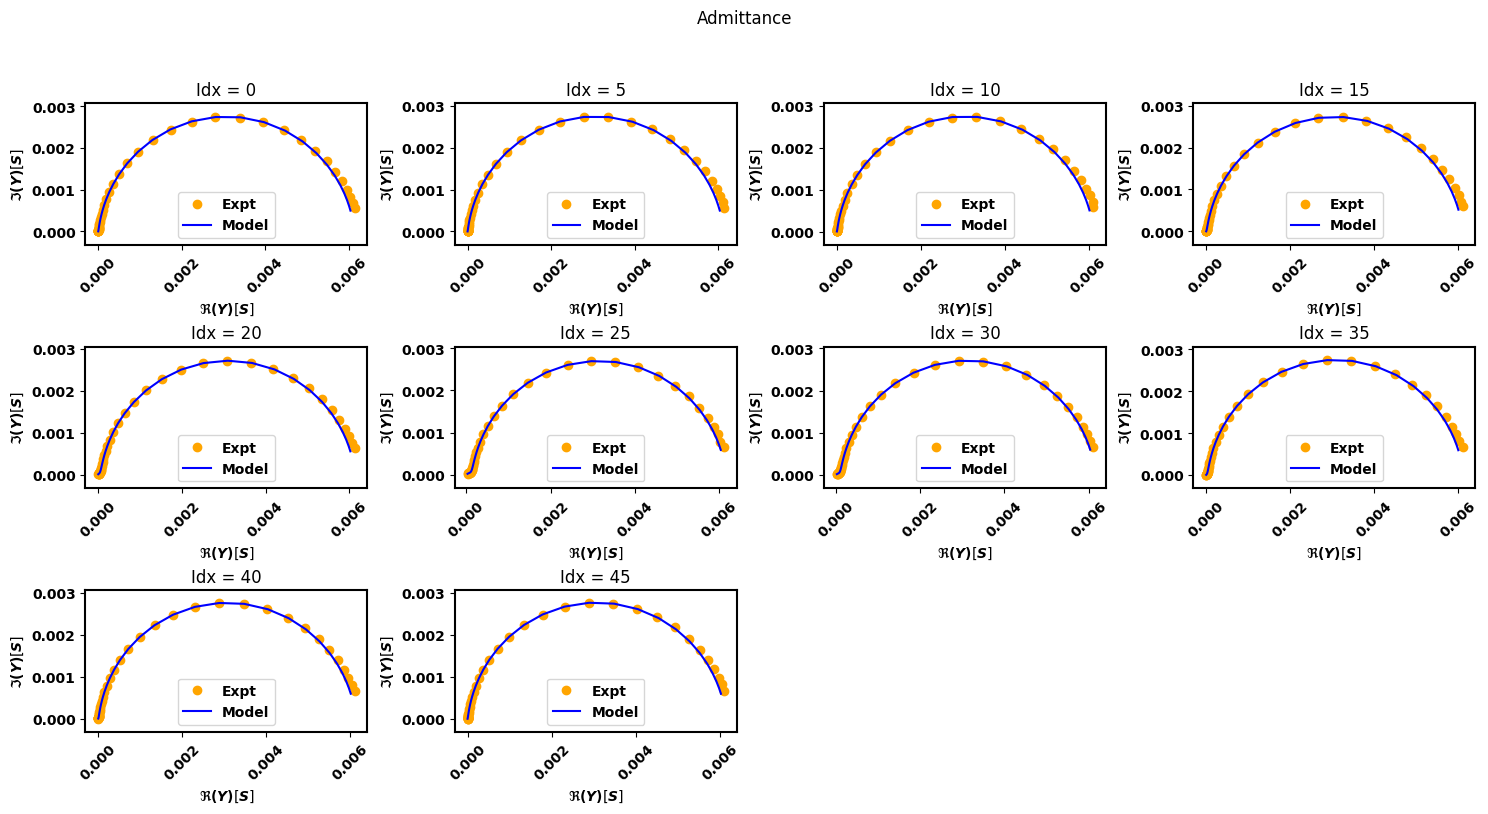

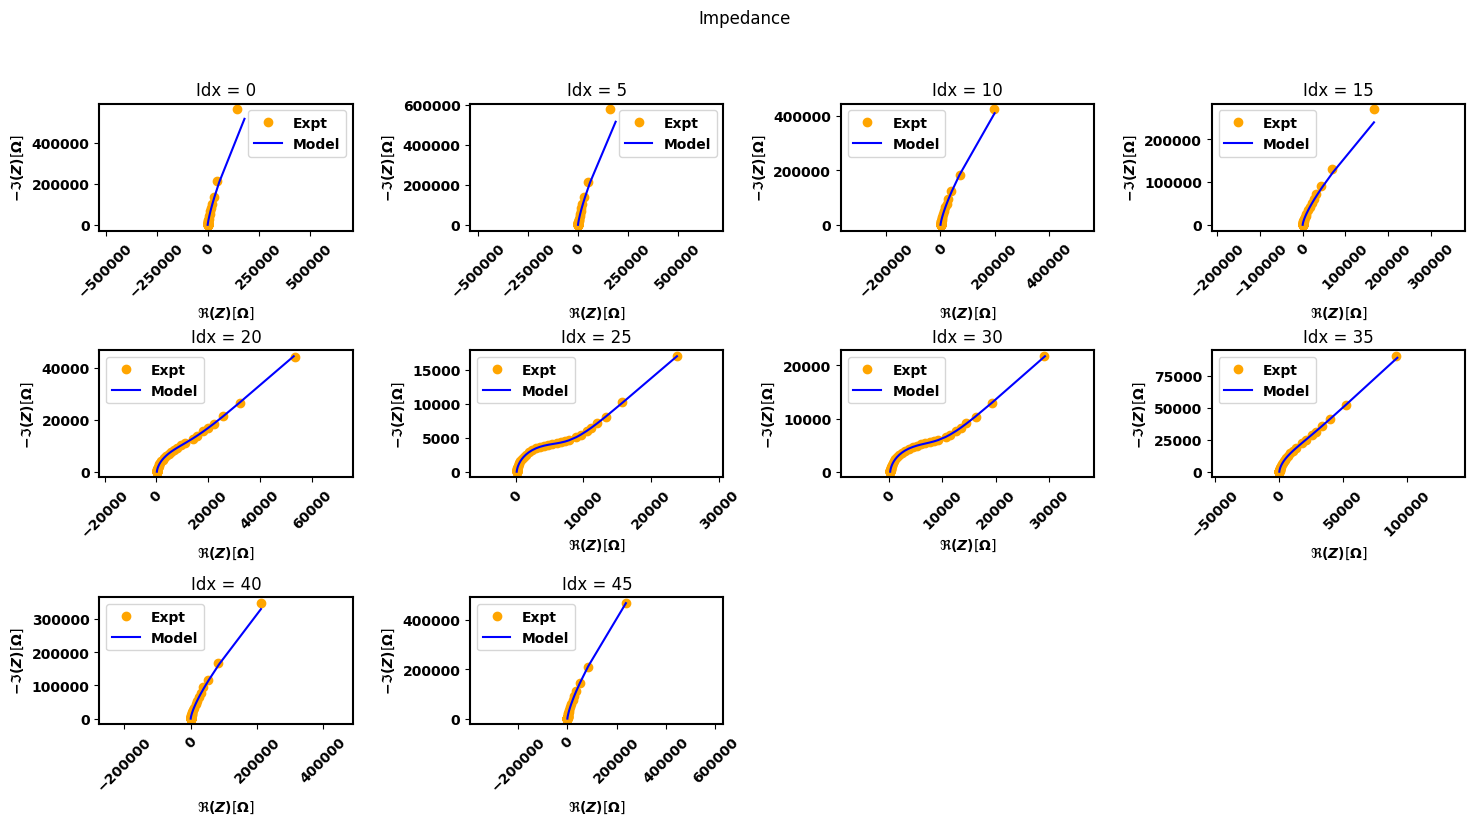

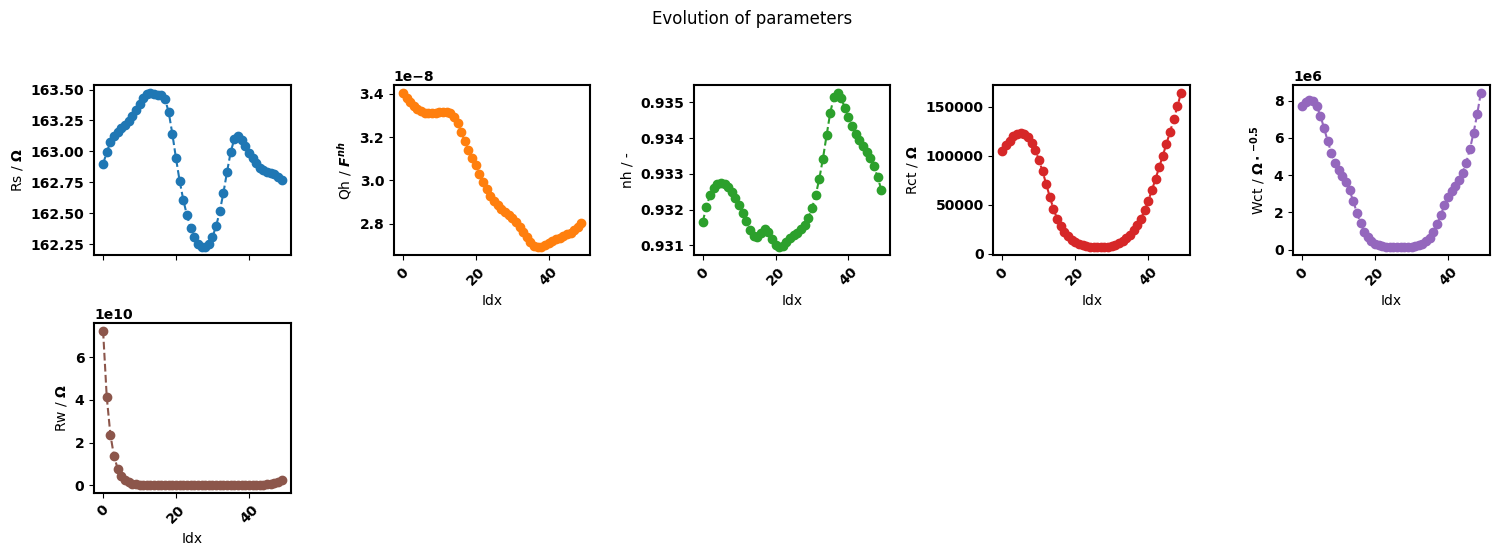

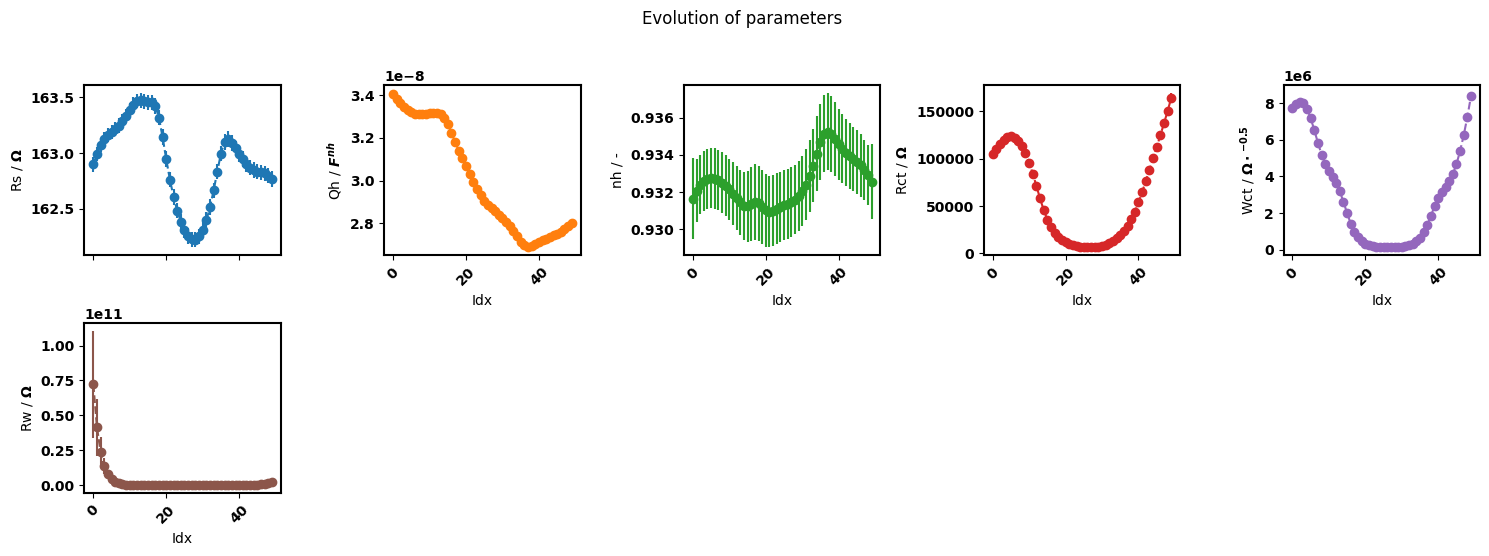

In [9]:
popt, perr, chisqr, chitot, AIC = eis_redox_sigma.fit_simultaneous(method = 'tnc')
eis_redox_sigma.plot_nyquist(5)
eis_redox_sigma.plot_params(labels=labels)
eis_redox_sigma.plot_params(True, labels=labels)


Using prefit

Optimization complete
total time is 0:00:08.778314 

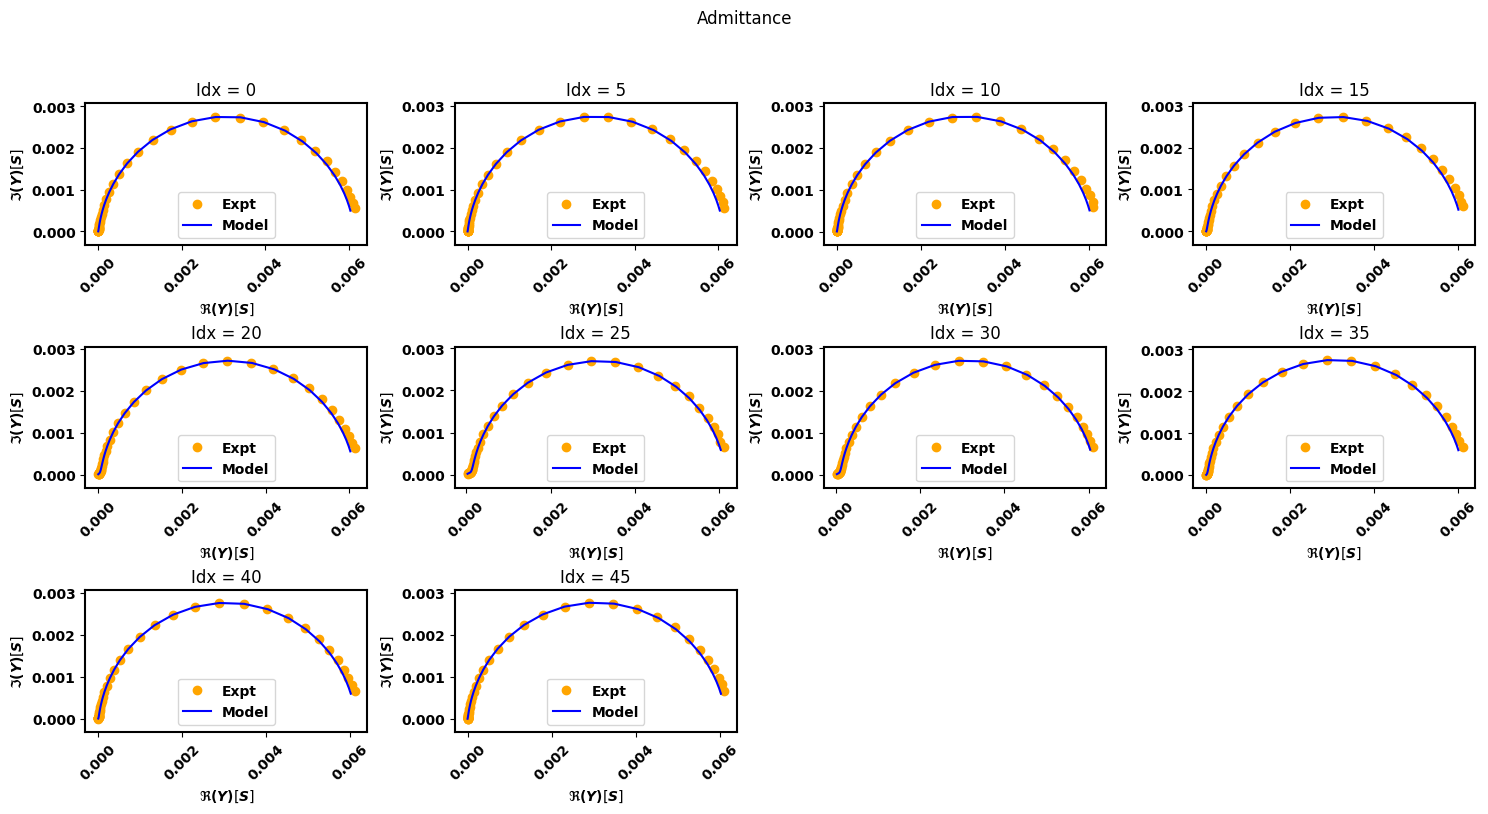

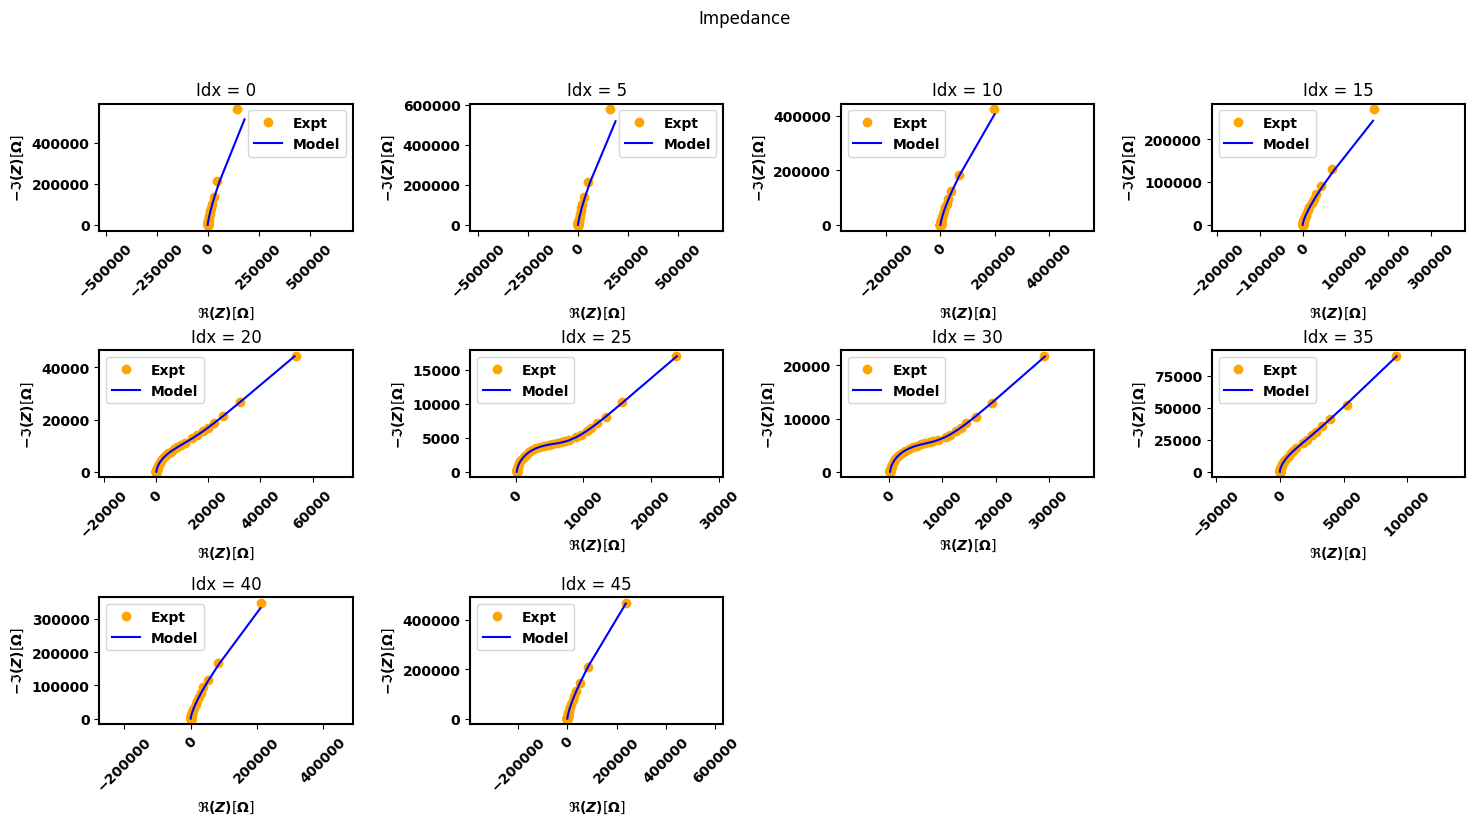

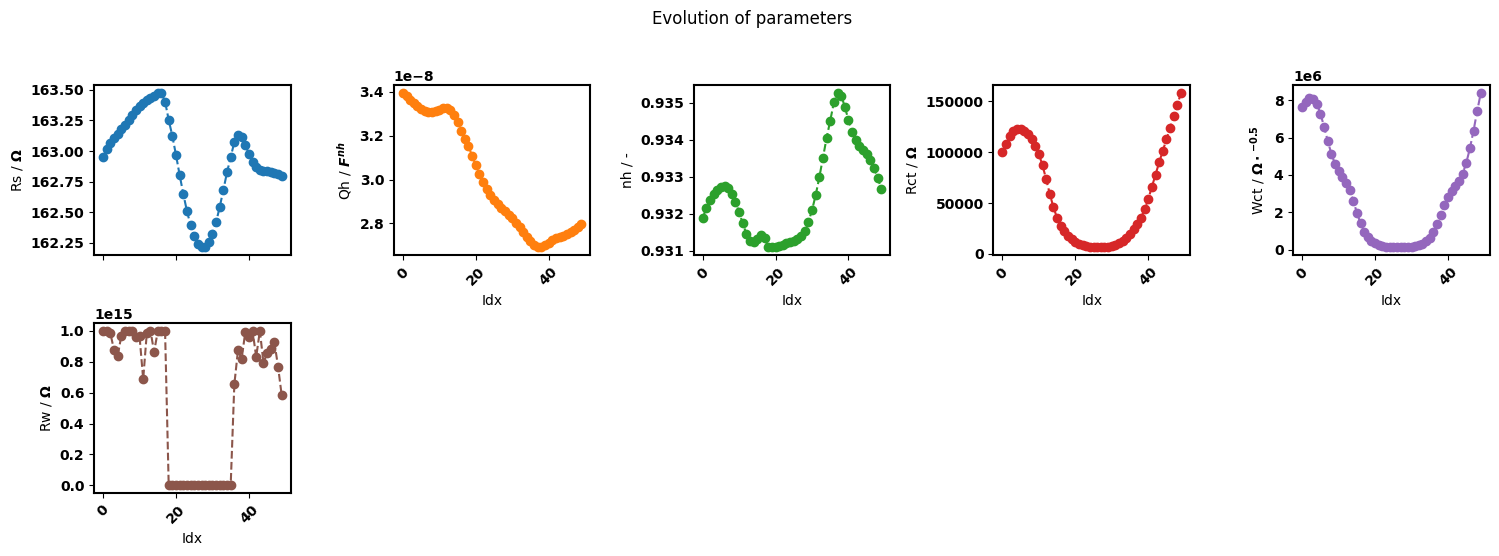

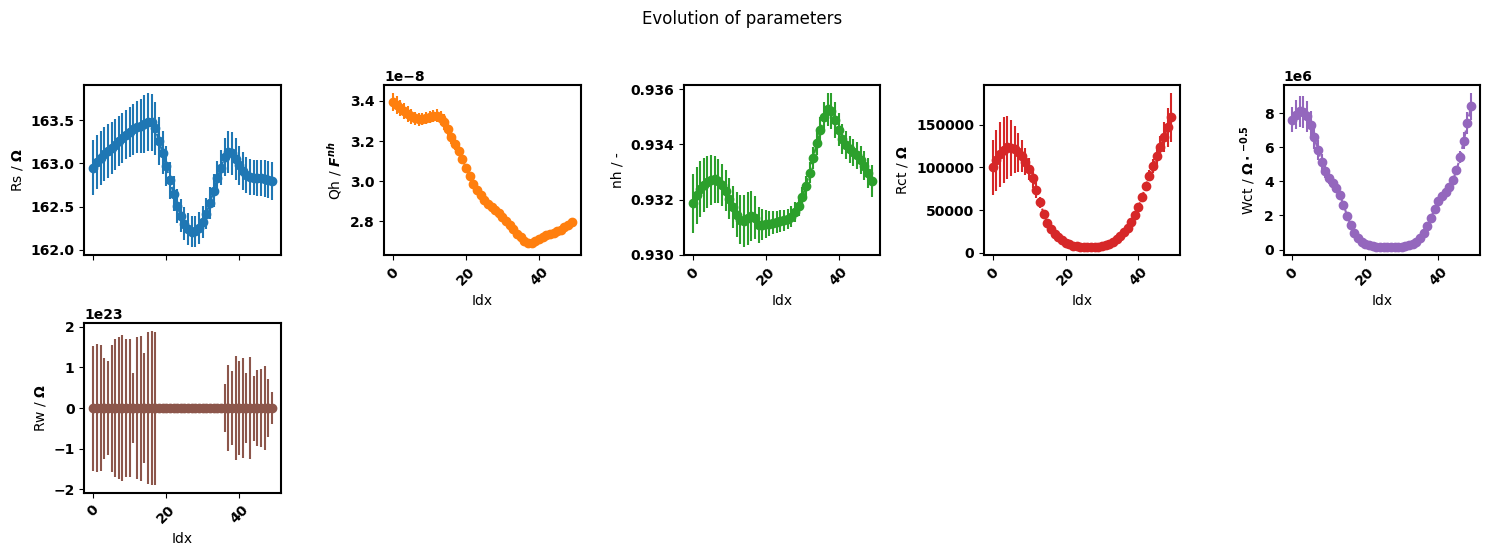

In [10]:
popt, perr, chisqr, chitot, AIC = eis_redox_sigma.fit_simultaneous_zero()
eis_redox_sigma.plot_nyquist(5)
eis_redox_sigma.plot_params(labels=labels)
eis_redox_sigma.plot_params(True, labels=labels)

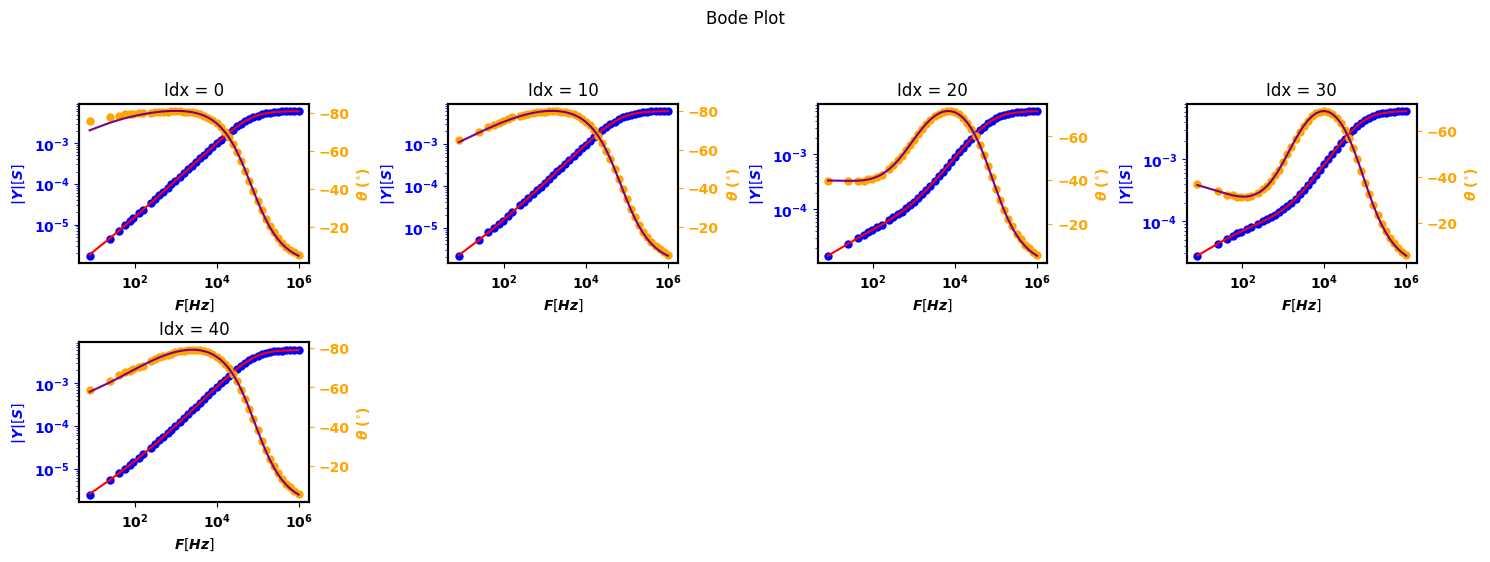

In [11]:
eis_redox_sigma.plot_bode(steps = 10)

2. Using the modulus as weighting

There are many cases where we do not have the data for the standard deviation of the admittance or impedance. ``pymultieis`` offers other weighting options. 
In this second example we shall fit using the modulus as the weighting. All you need do is set the weight to the string "modulus".


Using initial

Optimization complete
total time is 0:00:06.505925 

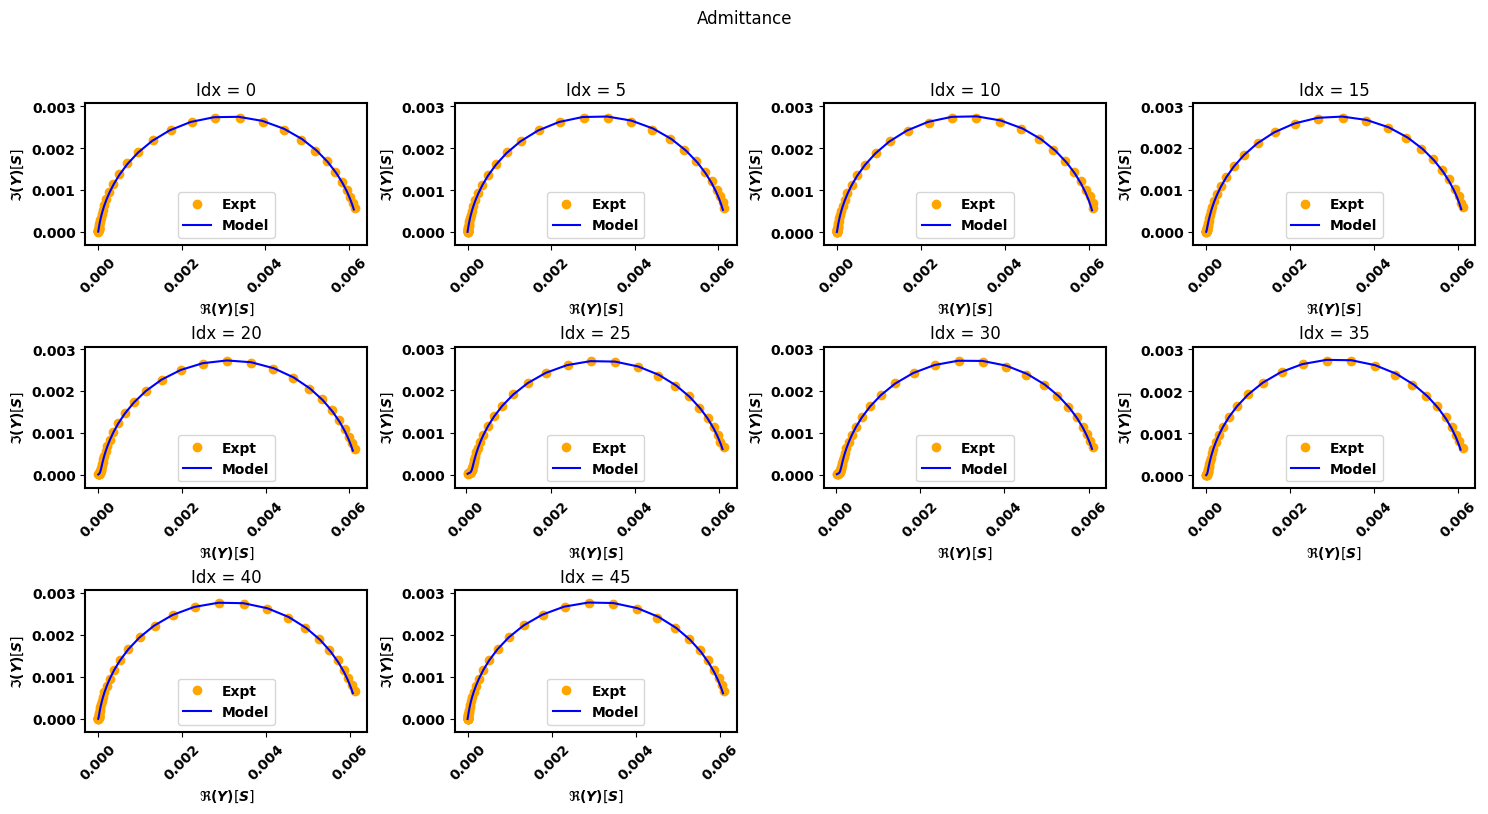

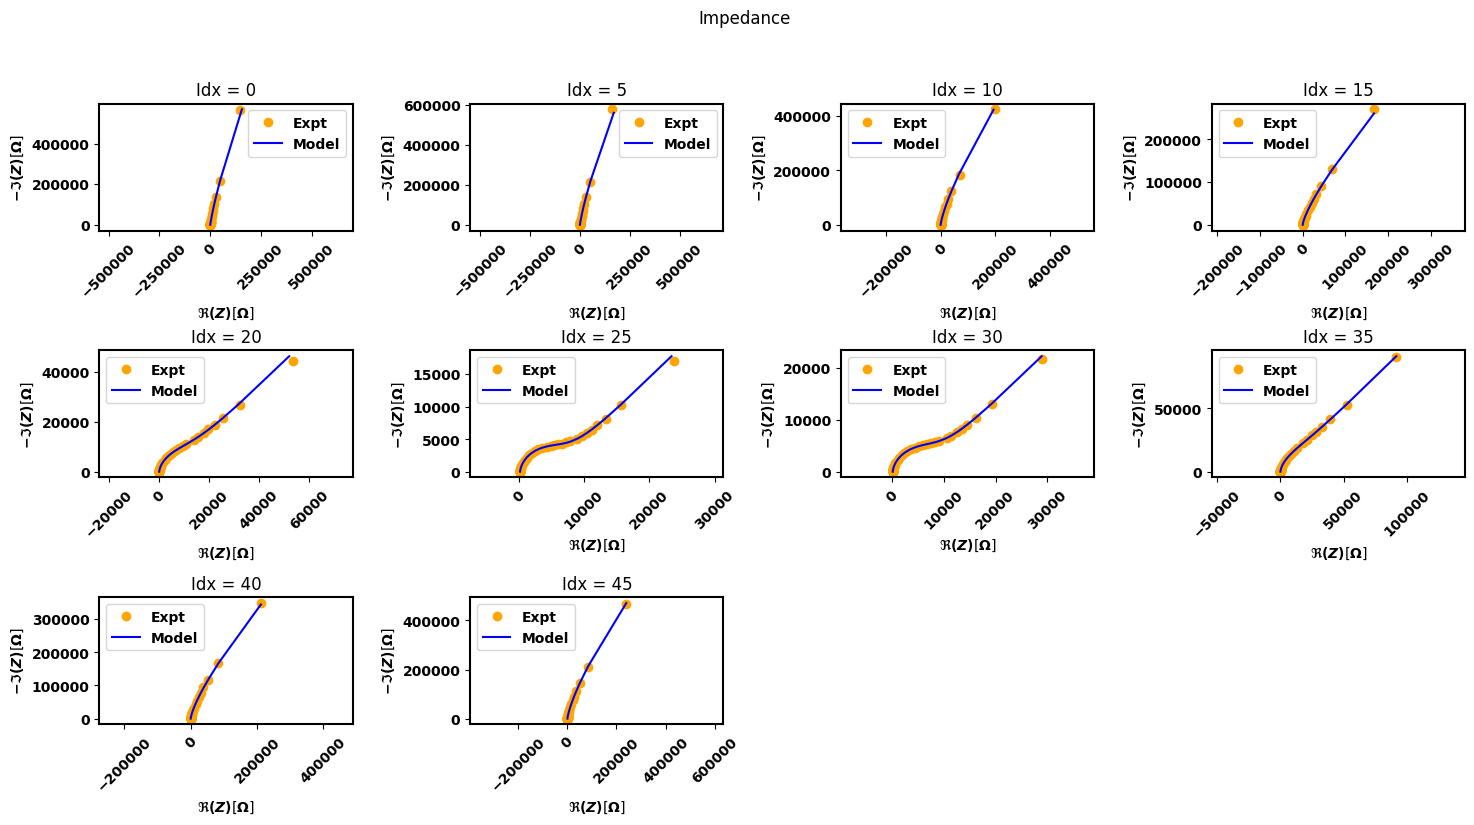

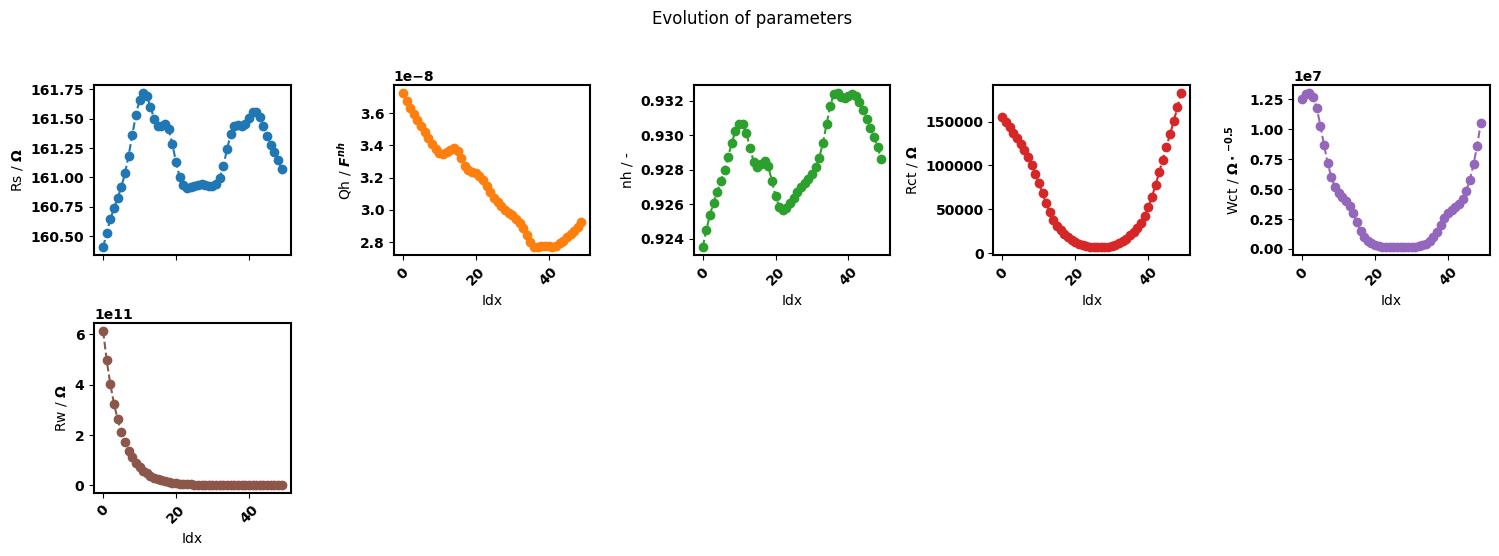

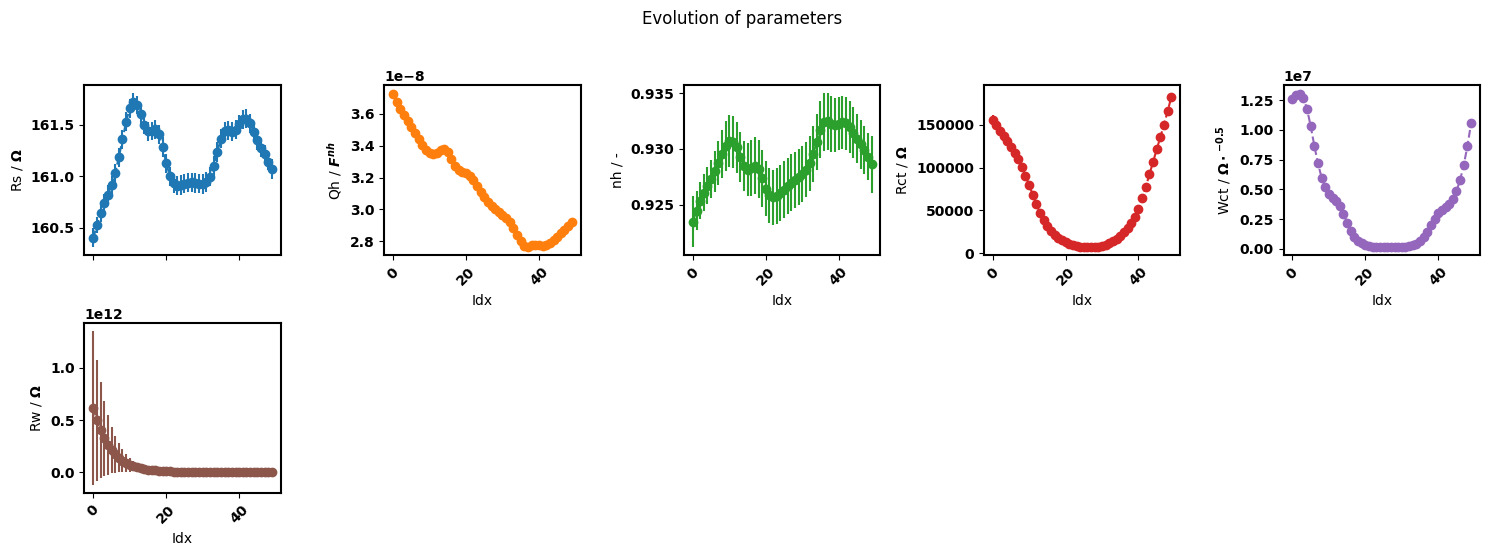

In [12]:
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'tnc')
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(labels=labels)
eis_redox_modulus.plot_params(True, labels=labels)


Using prefit

Optimization complete
total time is 0:00:04.768274 

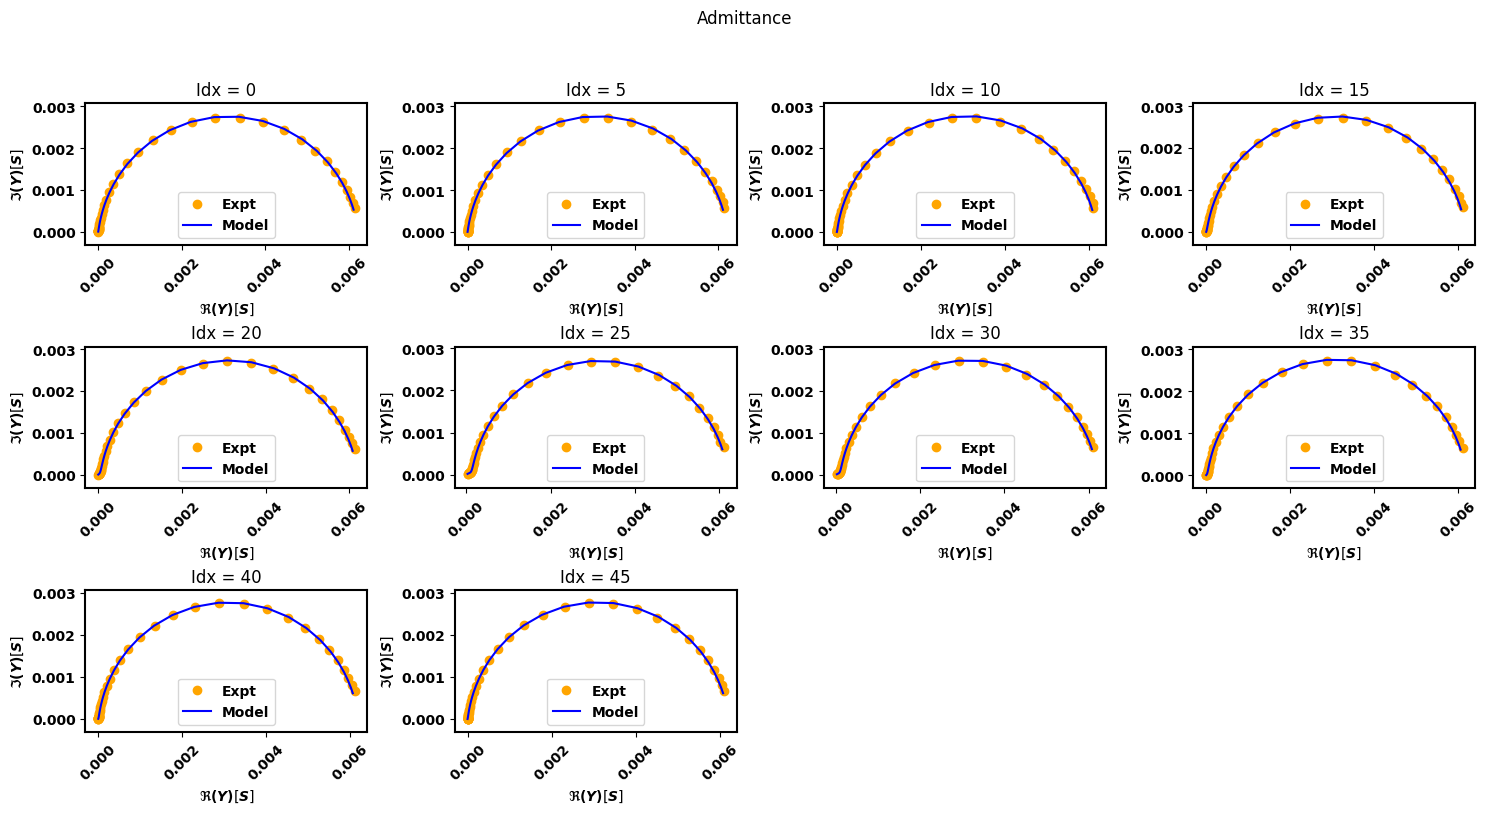

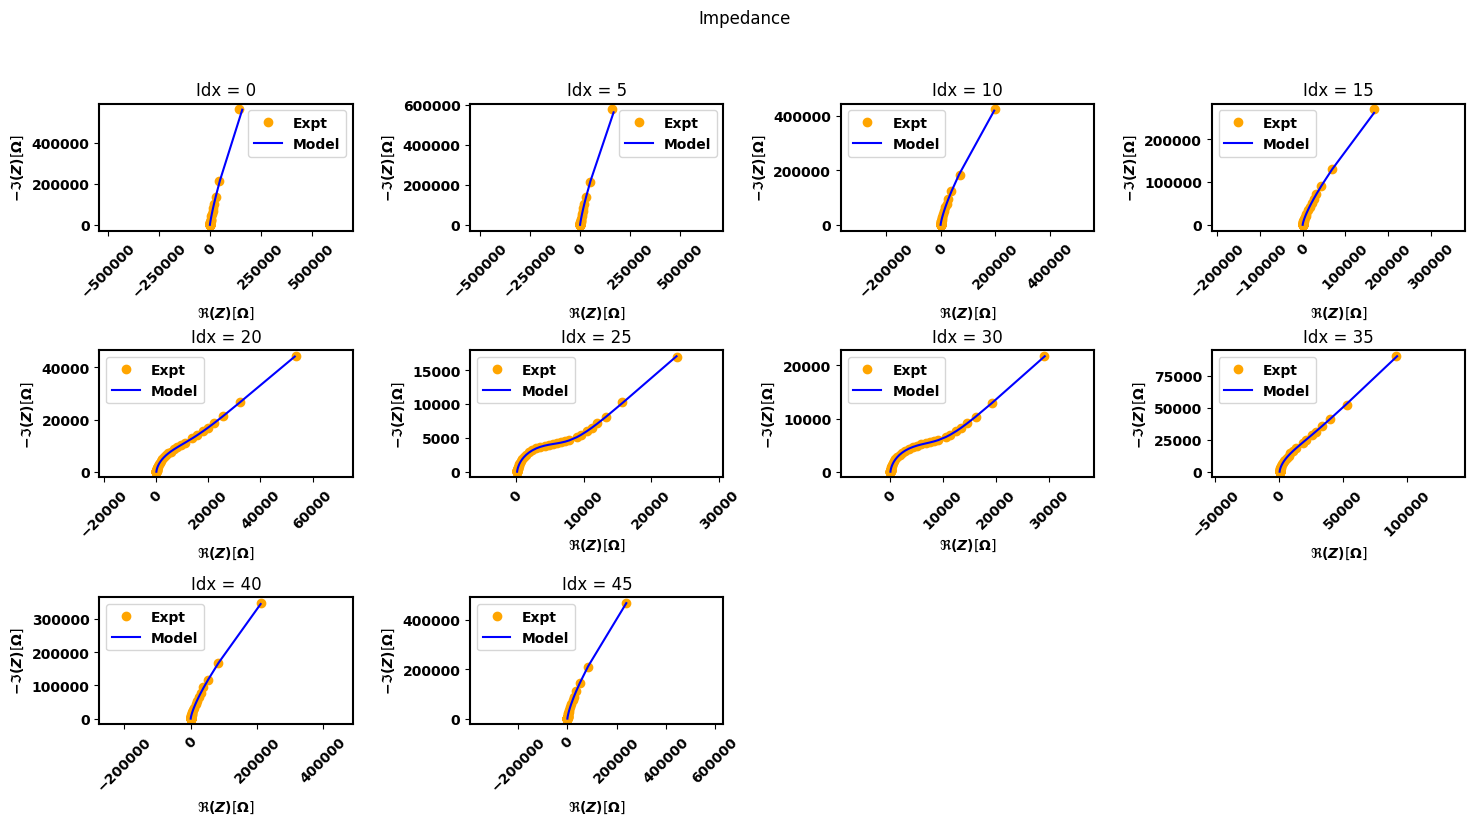

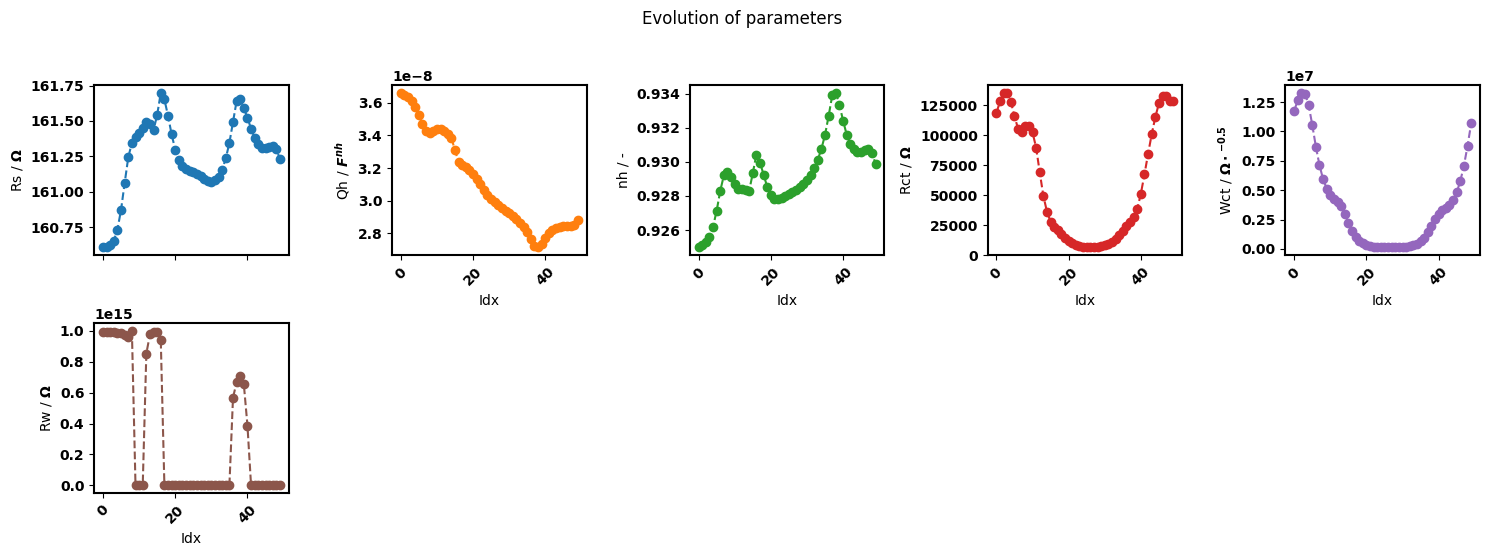

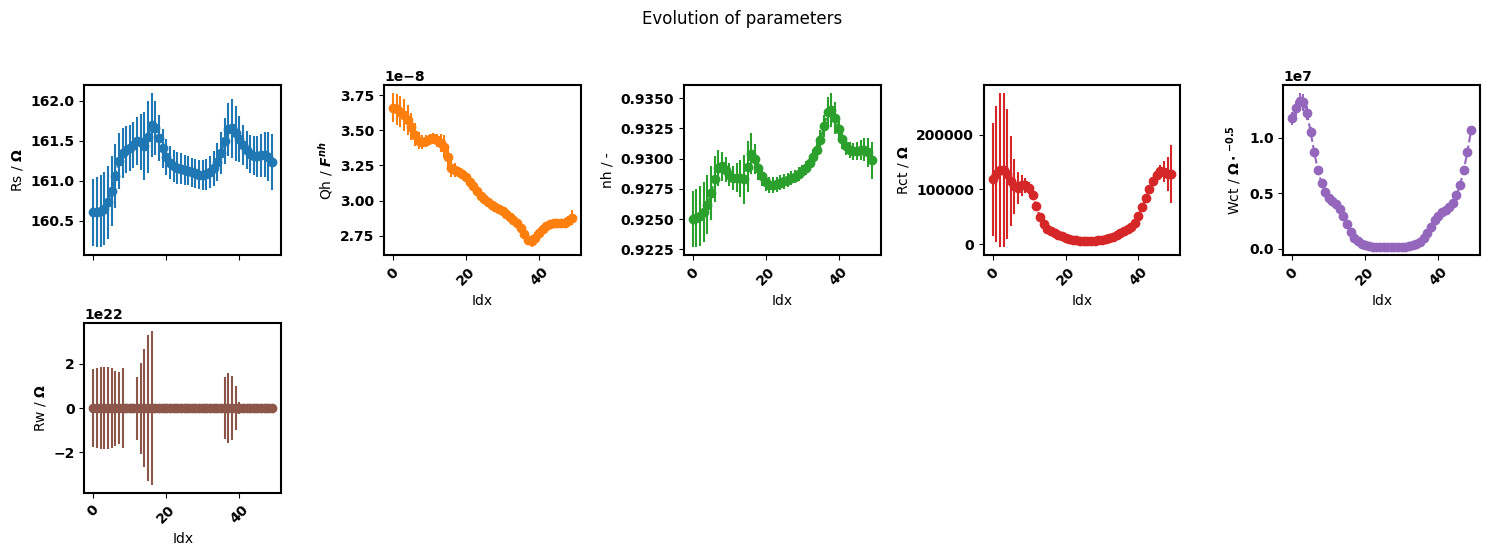

In [13]:
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous_zero()
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(labels=labels)
eis_redox_modulus.plot_params(True, labels=labels)


Using initial

Optimization complete
total time is 0:00:06.216769 
Using prefit
fitting spectra 0
fitting spectra 1
fitting spectra 2
fitting spectra 3
fitting spectra 4
fitting spectra 5
fitting spectra 6
fitting spectra 7
fitting spectra 8
fitting spectra 9
fitting spectra 10
fitting spectra 11
fitting spectra 12
fitting spectra 13
fitting spectra 14
fitting spectra 15
fitting spectra 16
fitting spectra 17
fitting spectra 18
fitting spectra 19
fitting spectra 20
fitting spectra 21
fitting spectra 22
fitting spectra 23
fitting spectra 24
fitting spectra 25
fitting spectra 26
fitting spectra 27
fitting spectra 28
fitting spectra 29
fitting spectra 30
fitting spectra 31
fitting spectra 32
fitting spectra 33
fitting spectra 34
fitting spectra 35
fitting spectra 36
fitting spectra 37
fitting spectra 38
fitting spectra 39
fitting spectra 40
fitting spectra 41
fitting spectra 42
fitting spectra 43
fitting spectra 44
fitting spectra 45
fitting spectra 46
fitting spectra 47
fitting spectra 4

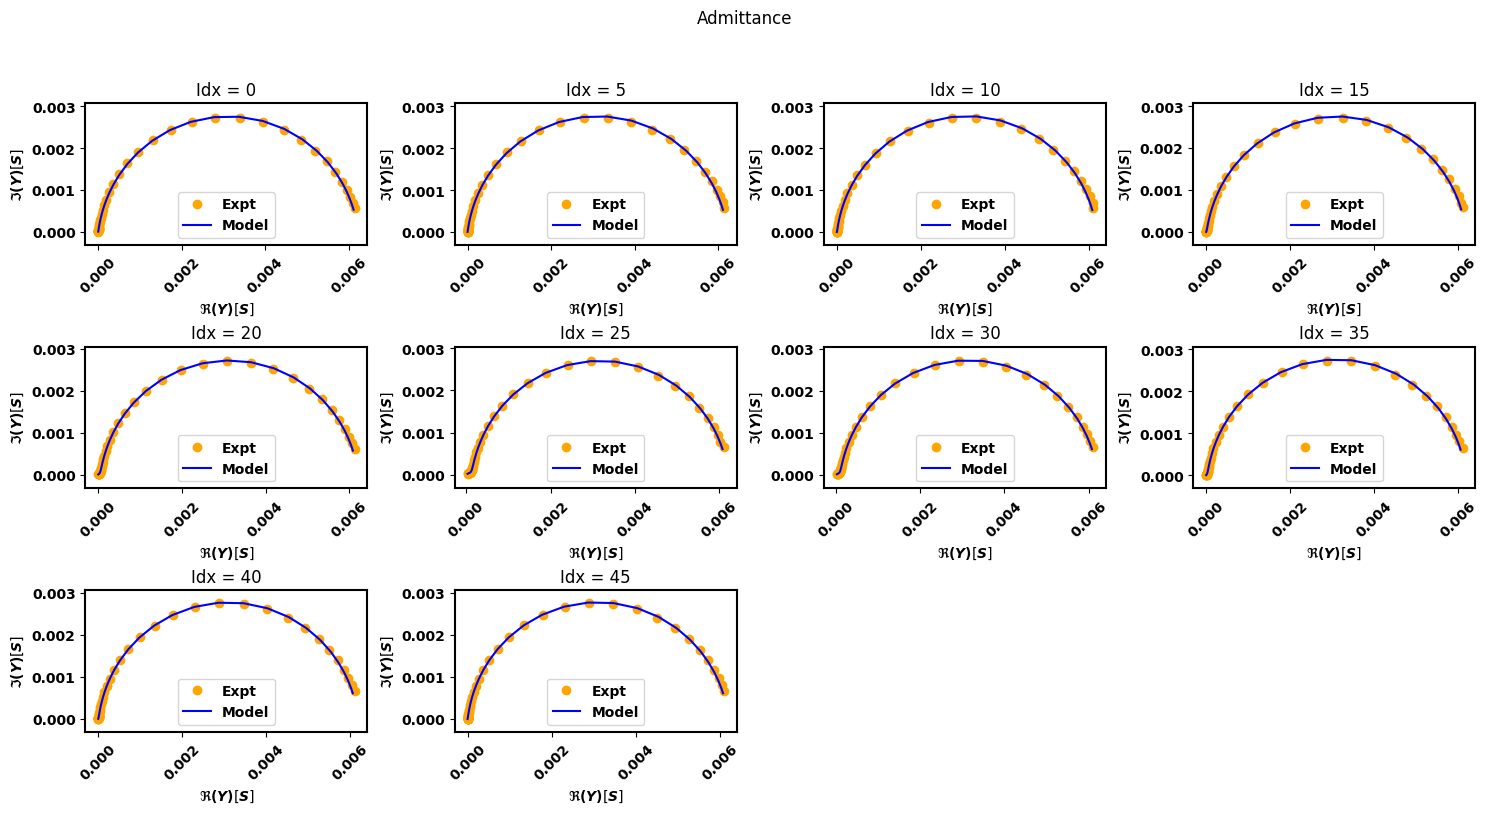

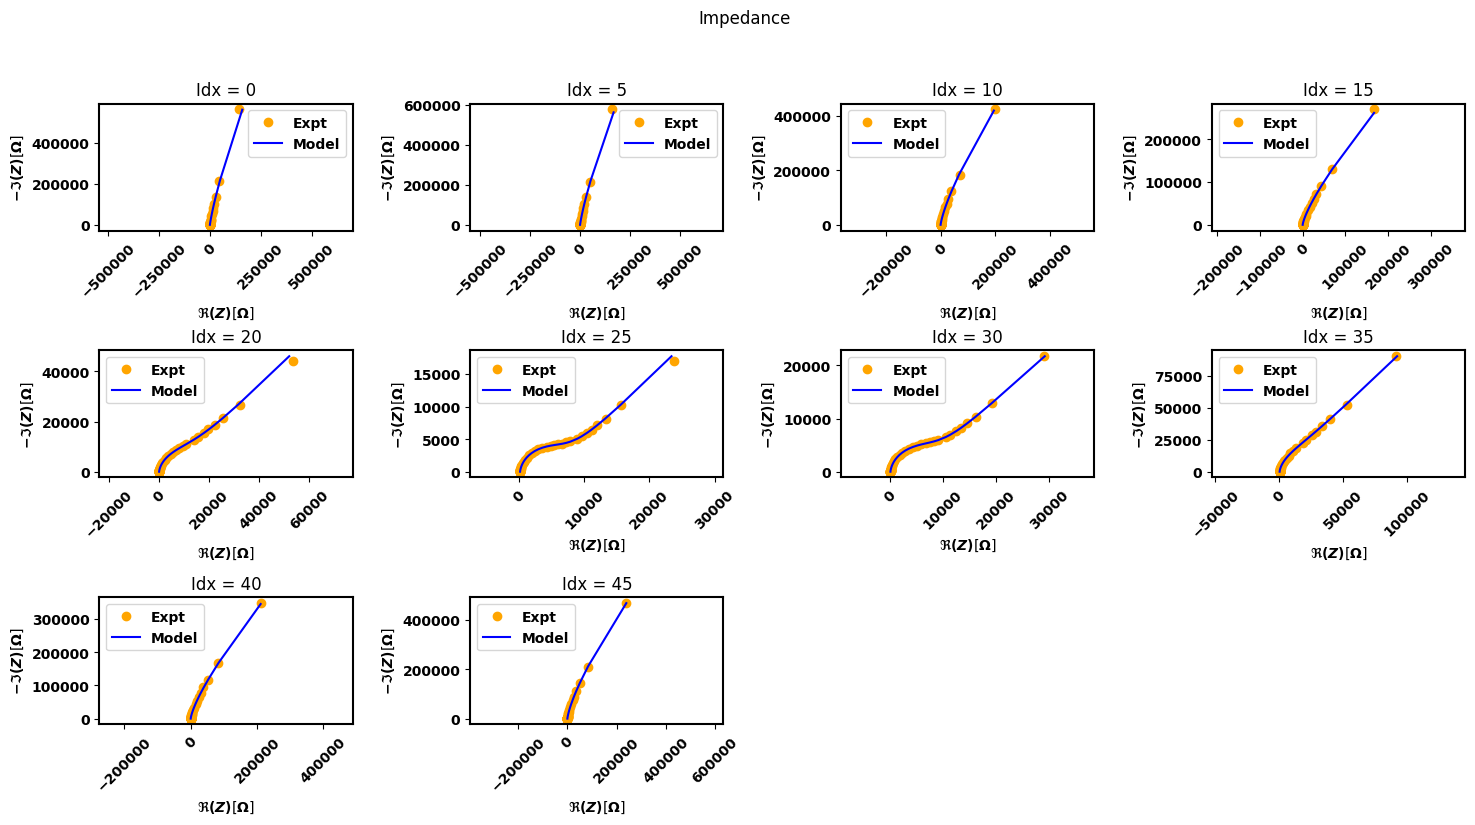

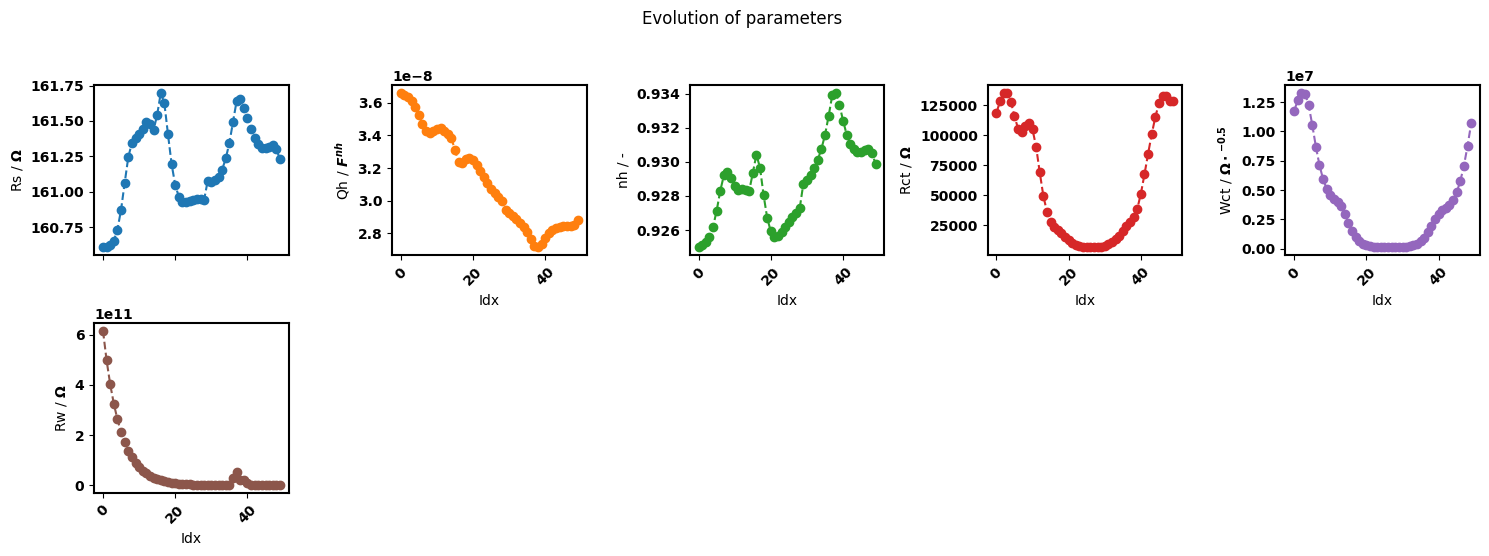

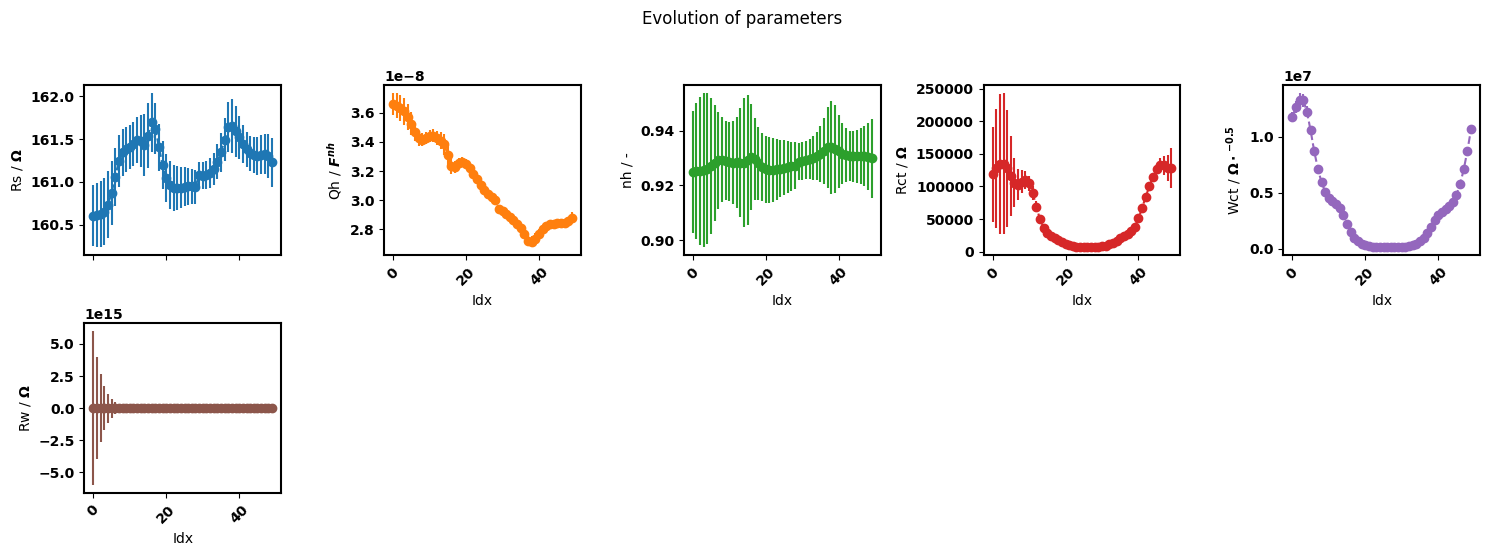

In [14]:
# Reinstantiate class
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'tnc')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_sequential(indices=None)
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)


Using initial
0: loss=4.119e-01
10000: loss=4.565e-05
20000: loss=3.768e-05
30000: loss=3.753e-05
40000: loss=3.749e-05
50000: loss=3.748e-05
60000: loss=3.747e-05
70000: loss=3.746e-05
80000: loss=3.746e-05
90000: loss=3.745e-05
Optimization complete
total time is 0:01:38.712091 

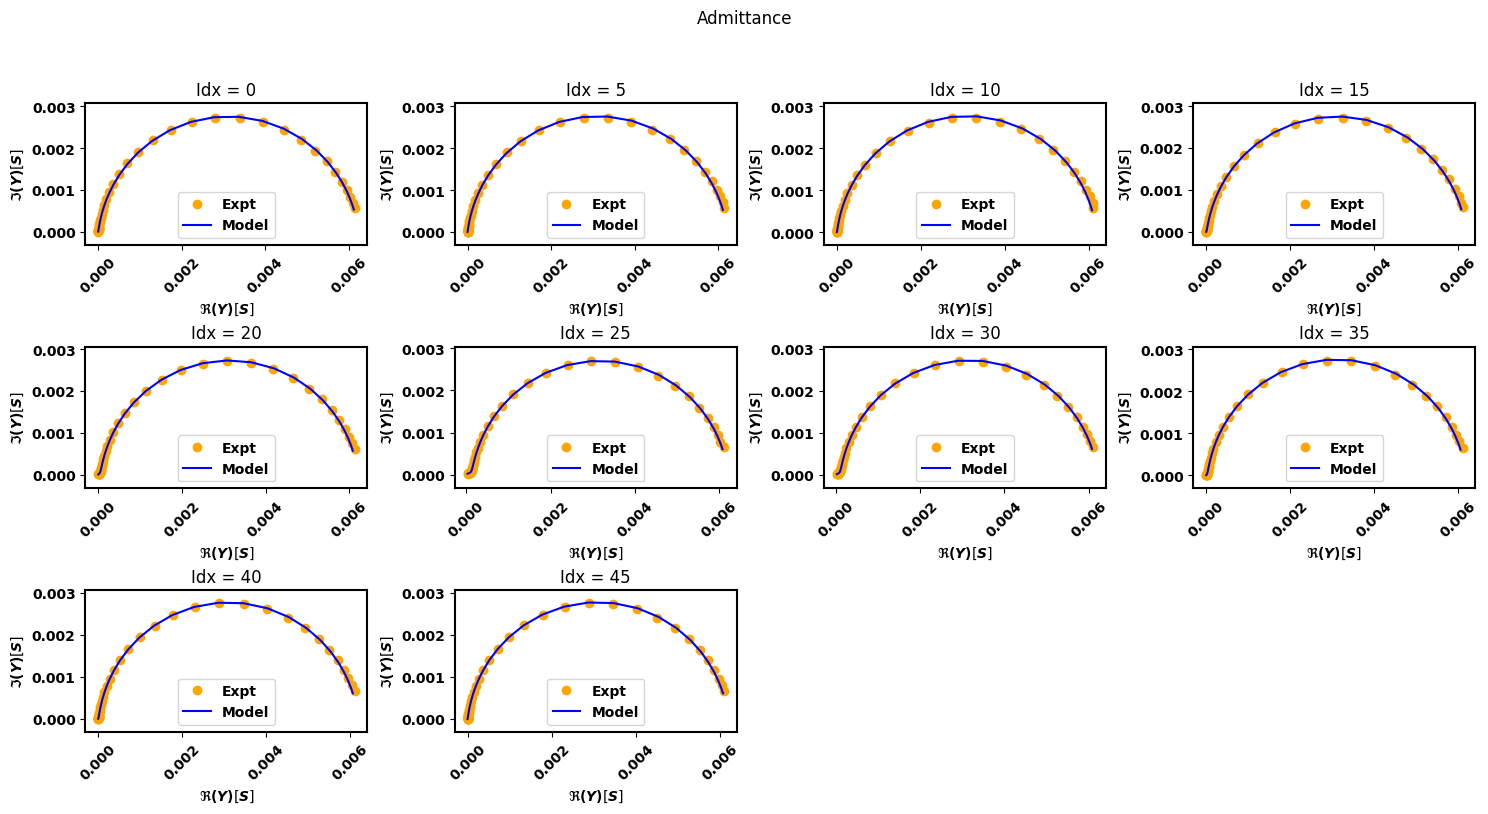

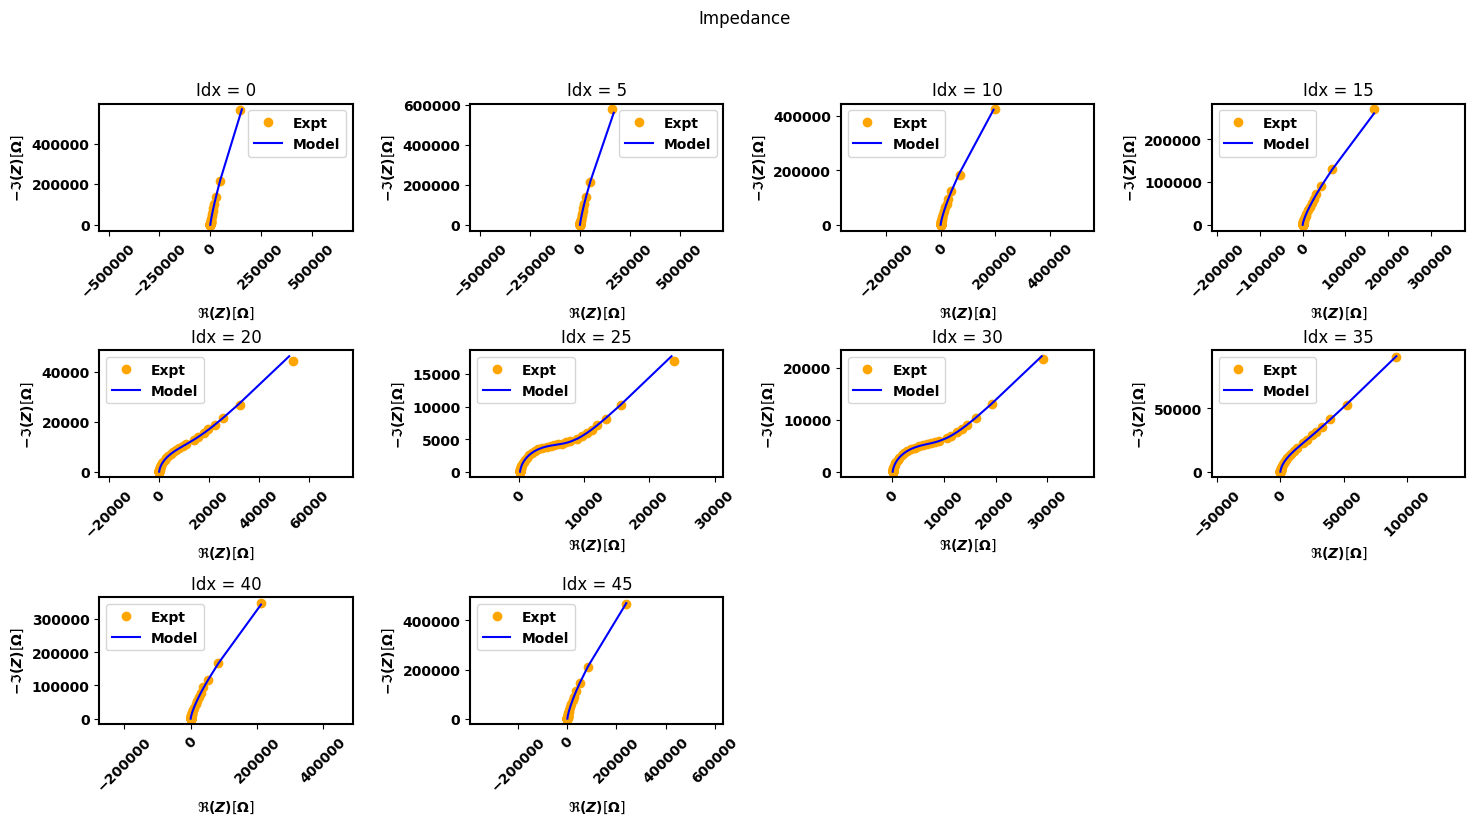

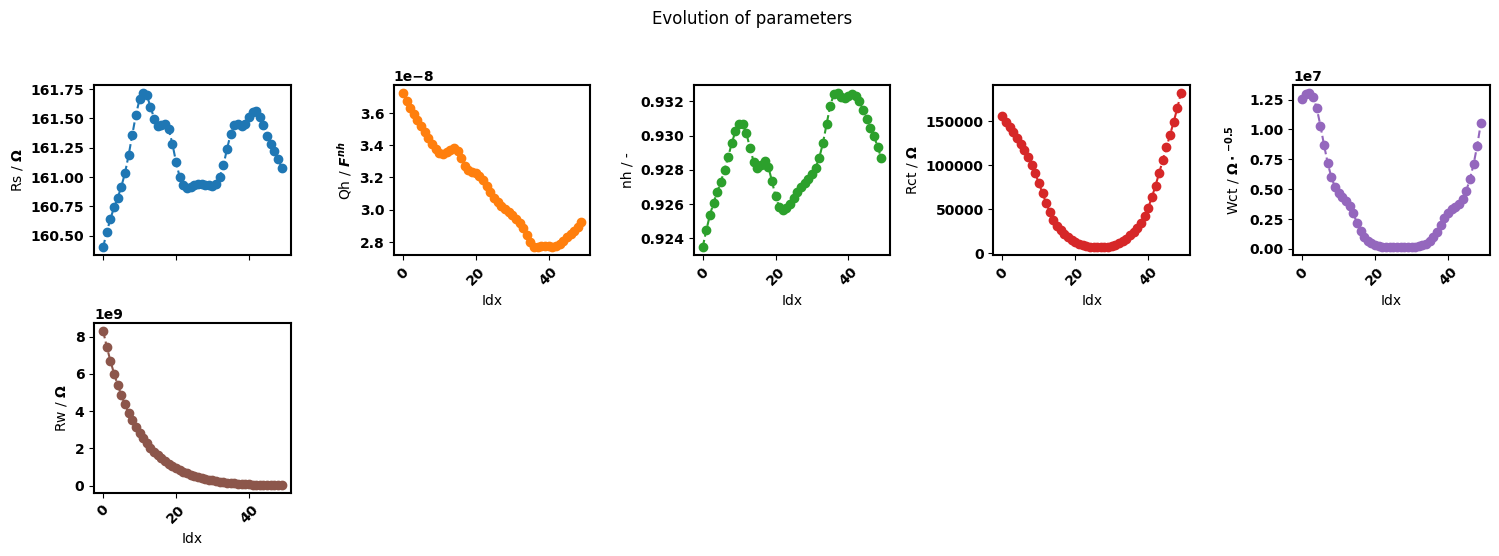

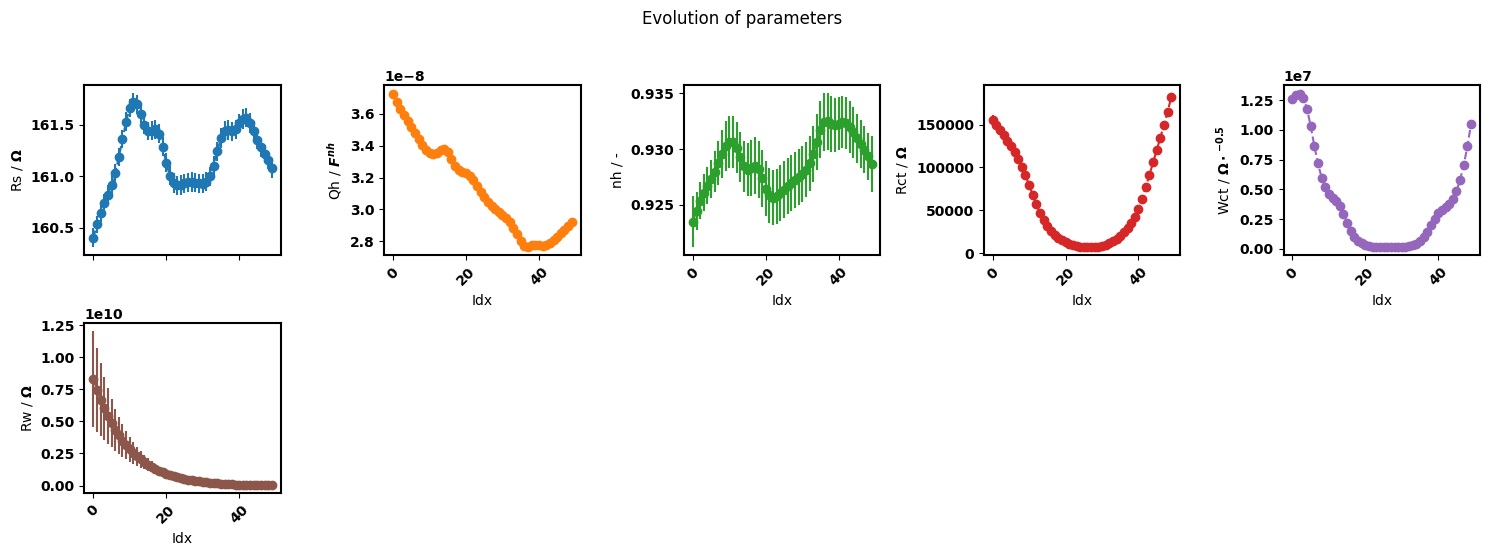

In [15]:
# Reinstantiate class and fit stochastic
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_stochastic()
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)


Using prefit
fitting spectra 0
fitting spectra 1
fitting spectra 2
fitting spectra 3
fitting spectra 4
fitting spectra 5
fitting spectra 6
fitting spectra 7
fitting spectra 8
fitting spectra 9
fitting spectra 10
fitting spectra 11
fitting spectra 12
fitting spectra 13
fitting spectra 14
fitting spectra 15
fitting spectra 16
fitting spectra 17
fitting spectra 18
fitting spectra 19
fitting spectra 20
fitting spectra 21
fitting spectra 22
fitting spectra 23
fitting spectra 24
fitting spectra 25
fitting spectra 26
fitting spectra 27
fitting spectra 28
fitting spectra 29
fitting spectra 30
fitting spectra 31
fitting spectra 32
fitting spectra 33
fitting spectra 34
fitting spectra 35
fitting spectra 36
fitting spectra 37
fitting spectra 38
fitting spectra 39
fitting spectra 40
fitting spectra 41
fitting spectra 42
fitting spectra 43
fitting spectra 44
fitting spectra 45
fitting spectra 46
fitting spectra 47
fitting spectra 48
fitting spectra 49

Optimization complete
total time is 0:01:41.0

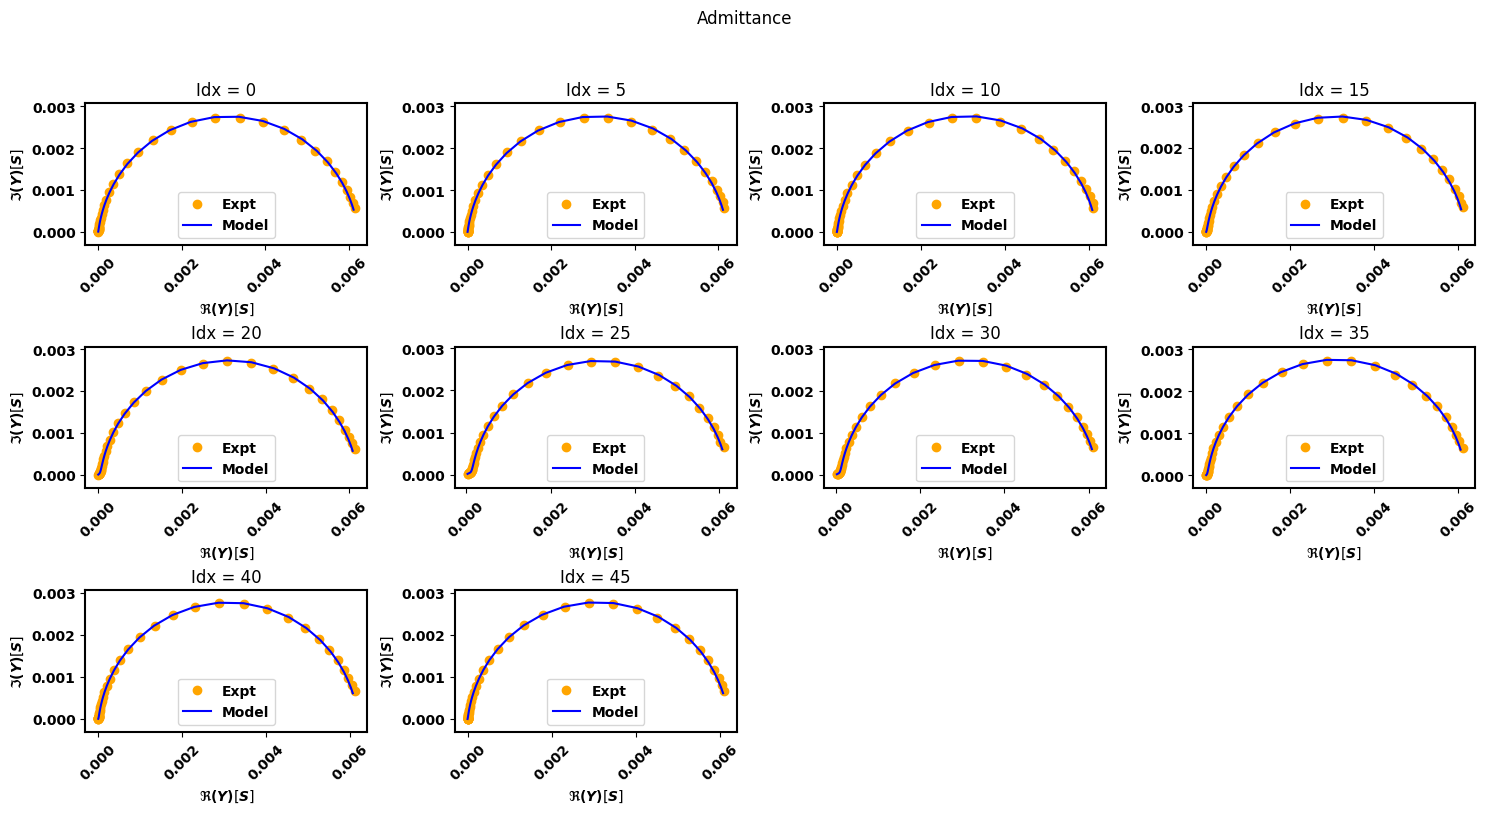

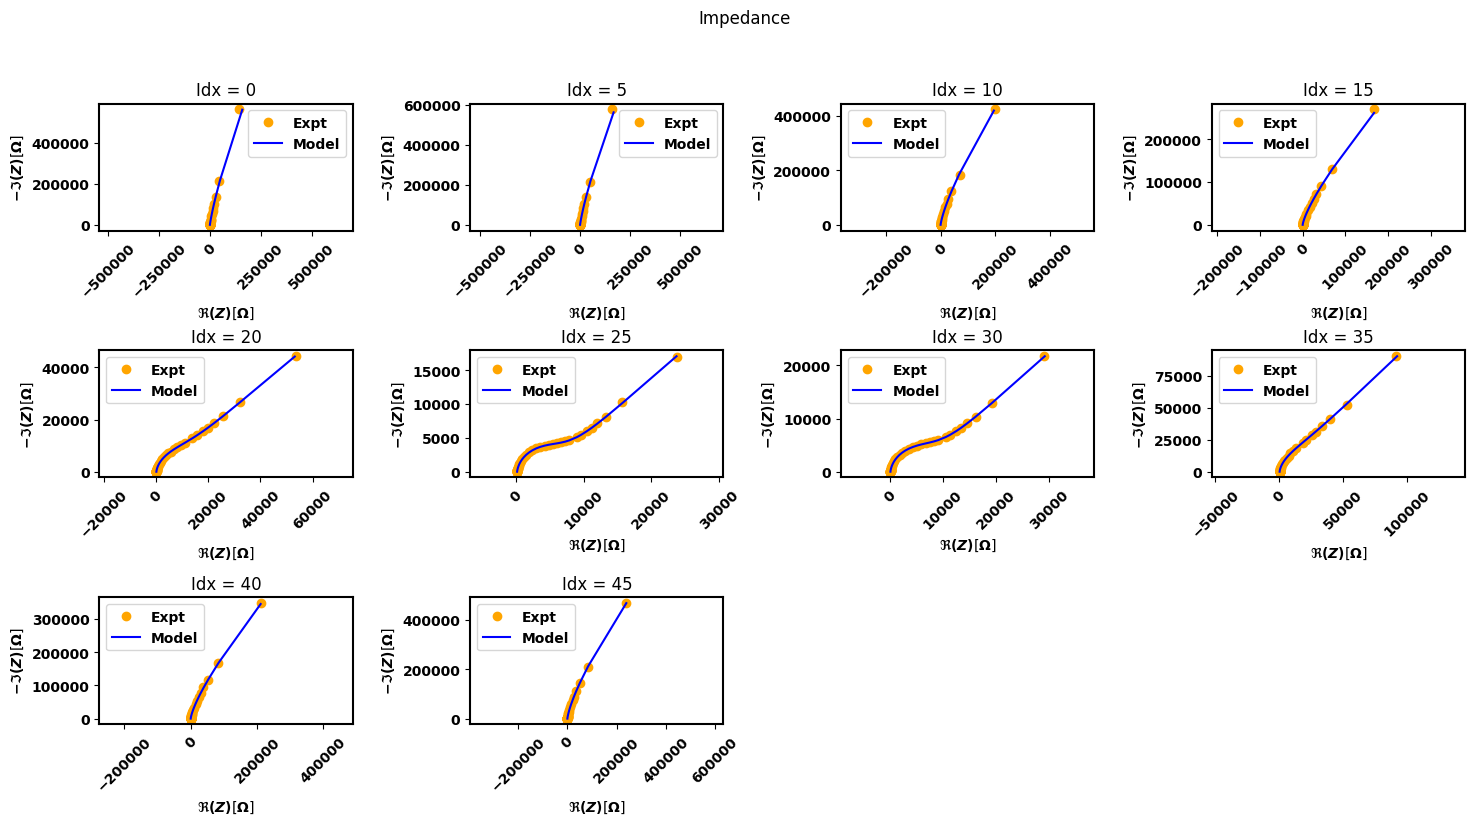

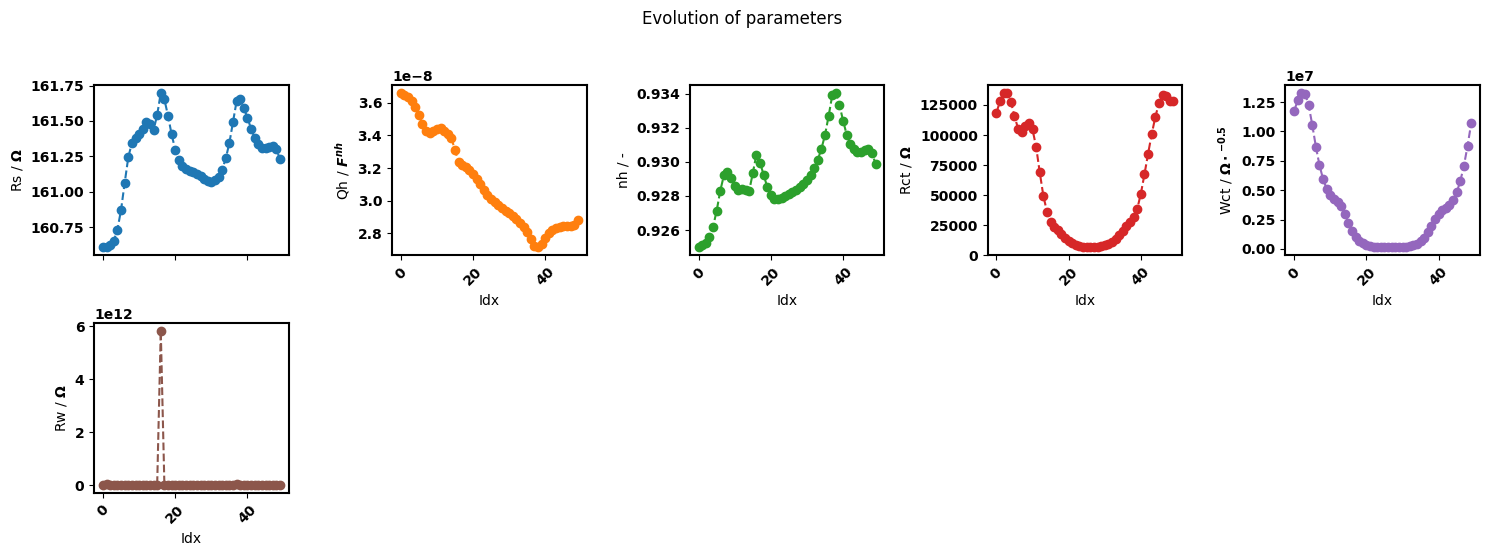

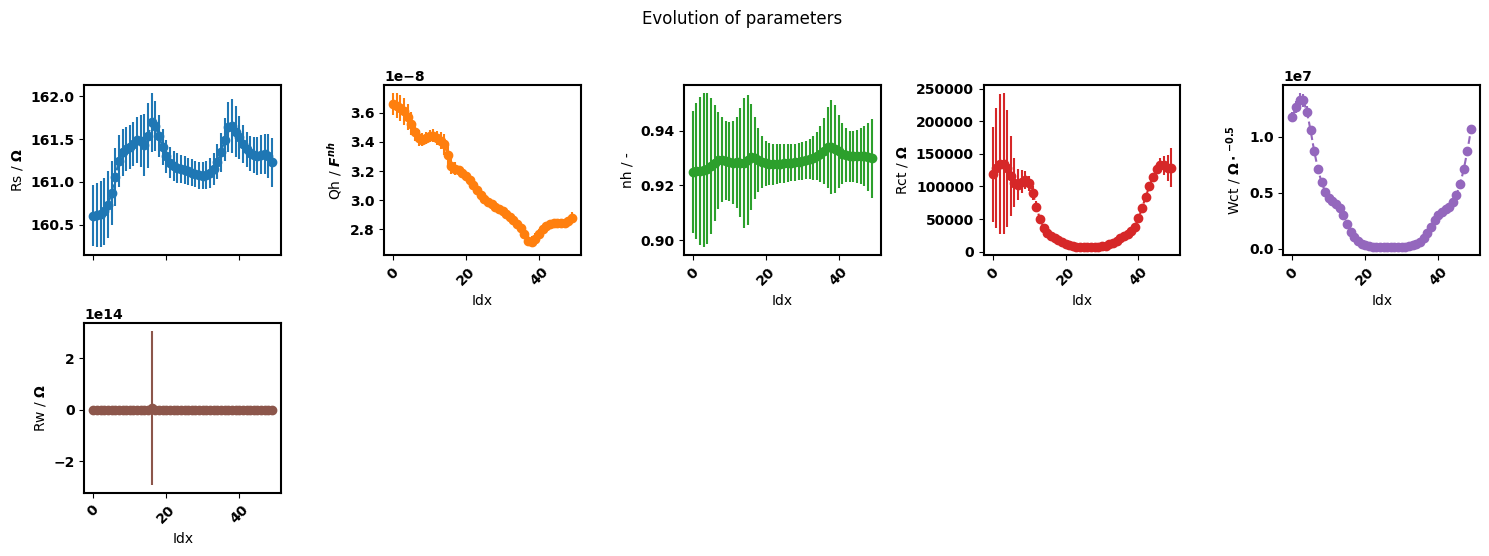

In [16]:
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_sequential(indices=None)
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

## Running the Bootstrap MonteCarlo option

In [17]:
# Reinstantiate class and fit stochastic
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'tnc')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.compute_perr_mc(n_boots=500)
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)


Using initial

Optimization complete
total time is 0:00:06.295162 
Please run fit_simultaneous() or fit_stochastic()
              on your data before running the compute_perr_mc() method.
              ignore this message if you did.


## Keeping a parameter constant

3. Saving the plots

In [ ]:
eis_redox_modulus.save_plot_nyquist(steps=10, fname='example_results')
eis_redox_modulus.save_plot_bode(steps=10, fname='example_results')
eis_redox_modulus.save_plot_params(False, fname='example_results')

4. saving the results

In [ ]:
eis_redox_modulus.save_results(fname='example_results')